# Set Up

## Colab Installation

Run the following code block if you are using this Jupyter notebook in Google Colab. Otherwise skip to importing the packages.

In [2]:
# Run these statements if you are using Google Colab. Otherwise skip this step.
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!sudo apt install cm-super
!pip install git+https://github.com/QMCSoftware/QMCSoftware.git@SURE2024

  Cloning https://github.com/QMCSoftware/QMCSoftware.git (to revision SURE2024) to c:\users\waine\appdata\local\temp\pip-req-build-n4_vfvra
  Resolved https://github.com/QMCSoftware/QMCSoftware.git to commit d19070ff3ee86f69f57218b65808e72ba6741d82
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for qmcpy: filename=qmcpy-1.4.5-cp39-cp39-win_amd64.whl size=7695007 sha256=75d1045a48fad4d790fc2287e686b47b172df533ef825c27fbaa9090edf99a1f
  Stored in directory: C:\Users\waine\AppData\Local\Temp\pip-ephem-wheel-cache-x654y6qu\wheels\ae\92\8c\9c3620765e56b81faafbec8c64f5d2d942604061db0c3369a2
Successfully built qmcpy


  Running command git clone --filter=blob:none --quiet https://github.com/QMCSoftware/QMCSoftware.git 'C:\Users\waine\AppData\Local\Temp\pip-req-build-n4_vfvra'
  Running command git checkout -b SURE2024 --track origin/SURE2024
  branch 'SURE2024' set up to track 'origin/SURE2024'.
  Switched to a new branch 'SURE2024'


## Importing Packages

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from copy import deepcopy
import sympy as sy
import sympy.stats
# figpath = '' #this path sends the figures to the directory that you want
# savefigs = True  #save the figures on your disk if True
# imgfrmt = 'pdf' #kind of format to save figures as

# Definitions of Python Functions

The following functions are things that will be repeatedly used in the notebook so that there isn't duplicate code all over the place.

## Graphing Functions

The following functions are to help with graphing.

In [2]:
def make_grid(d=3, nper=2):
    """this function creates a nper^d x d matrix of grid points"""
    xpts = np.linspace(1/(2*nper), 1.0-1/(2*nper), nper)  # array of coordinate values
    xgrid = xpts  # initial grid
    n = nper  # initial length of grid
    for ii in range(1,d):
        xgrid0 = xgrid  # store the old grid
        xgrid = np.vstack((xgrid0, xpts[0] * np.ones((1, n))))  # stack the next coordinate
        for jj in range(1, nper):
            xgrid = np.hstack((xgrid, np.vstack((xgrid0, xpts[jj] * np.ones((1, n))))))
        n = n * nper  # update the length of the grid
    return xgrid.T  # take the transpose to that coordinates are columns

def plot_grid(xgrid, coord_to_plot=[0, 1], savefig=True, figpath=''):
    """Plots a dot grid."""
    n = xgrid.shape[0]
    d = xgrid.shape[1]
    coord_to_plot = np.minimum(coord_to_plot, [d, d]), # ensure that they are no more than d
    coord_to_plot = coord_to_plot[0]
    coord_to_plot = np.maximum(coord_to_plot, [1, 1]), # ensure that they are no less than 1
    coord_to_plot = coord_to_plot[0]
    fig, ax = plt.subplots()
    ax.plot(xgrid[:,coord_to_plot[0]-1], xgrid[:,coord_to_plot[1]-1], 'b.', markersize = 10, zorder=10, clip_on=False)
    ax.set_title(f"{n:.0f} Grid Points for $d = ${d:.0f}")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel(r'$x_{i%d}$'%(coord_to_plot[0]), fontsize=14)
    ax.set_ylabel(r'$x_{i%d}$'%(coord_to_plot[1]), fontsize=14)
    ax.set_aspect(1)
    if savefigs:
        fig.savefig(figpath + f"{n:.0f}gridpts_d{d:.0f}." + imgfrmt, format=imgfrmt)


In [3]:
def graph_kernel(bandwidths, lin_spaces, kernel, ylim_lst=[-0.05, 1.2]):
  """Graphs a given kernel, with given bandwidths, lin_spaces
  bandwidths = a list of bandwidths
  lin_spaces = a list of 3 integers: start, finish, and number of points"""
  ypts = np.linspace(lin_spaces[0], lin_spaces[1], lin_spaces[2])
  nband = len(bandwidths)
  fig, ax = plt.subplots(1, 3, figsize=(5*nband, 5))
  for ii in range(nband):
      ax[ii].plot(ypts,kernel(ypts/bandwidths[ii]) / bandwidths[ii])
      ax[ii].grid(False)
      ax[ii].set_ylim(ylim_lst)
      ax[ii].set_xlabel(r'$y$', fontsize=20)
      ax[ii].set_ylabel(r'$h = {%0.1f}$'%bandwidths[ii], fontsize=20)
    #   if (ii == 0):
    #       ax[ii].set_ylabel(r'$\widetilde{k}(y) = \exp(-(y/h)^2)/(\sqrt{\pi}h), \ h = {%0.1f}$'%bandwidths[ii], fontsize=20)
    #   else:
    #       ax[ii].set_ylabel(r'$h = {%0.1f}$'%bandwidths[ii], fontsize=20)

In [4]:
def generate_sobol_iid_graph(bandwidths, lin_spaces, kde, kernel, yiid, ysob, ylim_lst=[-0.05, 1.2]):
  """Generates a graph using IID and Sobol sample points.
  bandwidths = a list of bandwidths
  lin_spaces = a list of 3 integers: start, finish, and number of points
  kde = name of kde function
  kernel = name of kernel function
  yiid = set of iid points
  ysob = set of LD points generated with sobol sequence"""
  nband = len(bandwidths)
  yeval = np.linspace(lin_spaces[0], lin_spaces[1], lin_spaces[2])
  for ii in range(nband):
      rhovaliid = kde(kernel, yiid, bandwidths[ii], yeval)
      rhovalsob = kde(kernel, ysob, bandwidths[ii], yeval)
      fig,ax = plt.subplots()
      ax.plot(yeval, rhovaliid, label = "IID")
      ax.plot(yeval, rhovalsob, label = "Sobol")
      ax.legend()
      ax.set_ylim(ylim_lst)
      ax.set_title(f"$h = {bandwidths[ii]:.2f}$")

In [5]:
def generate_graphs(bandwidths, lin_spaces, kde, kernel, sample_points, ylim_lst=[-0.05, 1.2]):
  """
  Generate graphs involving a kde, kernel, and sample_points.
  sample_points is a list of IID, Sobol, Lattice, DNB2, and Halton points.
  """
  nband = len(bandwidths)
  yeval = np.linspace(lin_spaces[0], lin_spaces[1], lin_spaces[2])
  rho_list = list()
  for ii in range(nband):
      rhovaliid = kde(kernel, sample_points[0], bandwidths[ii], yeval)
      rhovalsob = kde(kernel, sample_points[1], bandwidths[ii], yeval)
      rhovallattice = kde(kernel, sample_points[2], bandwidths[ii], yeval)
      rhovaldnetb2 = kde(kernel, sample_points[3], bandwidths[ii], yeval)
      rhovalhalton = kde(kernel, sample_points[4], bandwidths[ii], yeval)
      fig, ax = plt.subplots()
      ax.plot(yeval, rhovaliid, label = "IID")
      ax.plot(yeval, rhovalsob, label = "Sobol")
      ax.plot(yeval, rhovallattice, label = "Lattice")
      ax.plot(yeval, rhovaldnetb2, label = "Digital Net B2")
      ax.plot(yeval, rhovalhalton, label = "Halton")
      ax.legend()
      ax.set_ylim(ylim_lst)
      ax.set_title(f"$h = {bandwidths[ii]:.2f}$")

## Generate Functions

The following functions are used to generate different types of sample points.

In [6]:
def gen_iid_and_sobol(dimen = 3, n = 2**12):
  """Generate IID and Sobol sample points based on given sample size and dimensions."""
  coord_wts = 2.0 ** (-np.array(range(0, dimen)))
  iidpts = qp.IIDStdUniform(dimen).gen_samples(n)
  sobpts = qp.Sobol(dimen).gen_samples(n)
  return (iidpts, sobpts)

def gen_iid_ld_pts(dimen = 3, n = 2**12):
  """
  Generate IID, Sobol, Lattic, DNB2, and Halton sample points,
  based on dimension and smaple size.
  """
  coord_wts = 2.0**(-np.array(range(0, dimen)))
  iidpts = qp.IIDStdUniform(dimen).gen_samples(n)
  sobpts = qp.Sobol(dimen).gen_samples(n)
  latticepts = qp.Lattice(dimen).gen_samples(n)
  dnetb2pts = qp.DigitalNetB2(dimen).gen_samples(n)
  haltonpts = qp.Halton(dimen).gen_samples(n)
  return (iidpts, sobpts, latticepts, dnetb2pts, haltonpts)

## Generating Points

Generating sequences of IID and LD points, with dimensions 1 and 3.

In [7]:
# dim = 1, n = 2**12
iidpts1, sobpts1, latticepts1, dnetb2pts1, haltonpts1 = gen_iid_ld_pts(dimen = 1, n = 2**12)
# print("iid: ", iidpts1)
# print("sobol: ", sobpts1)
# print("lattice: ", latticepts1)
# print("digital net B2: ", dnetb2pts1)
# print("halton: ", haltonpts1)

In [8]:
# dim = 1, n = 2**10
few_iidpts1, few_sobpts1, few_latticepts1, few_dnetb2pts1, few_haltonpts1 = gen_iid_ld_pts(dimen = 1, n = 2**10)
# print("iid: ", few_iidpts1)
# print("sobol: ", few_sobpts1)
# print("lattice: ", few_latticepts1)
# print("digital net B2: ", few_dnetb2pts1)
# print("halton: ", few_haltonpts1)

In [9]:
# dim = 1, n = 2**14
many_iidpts1, many_sobpts1, many_latticepts1, many_dnetb2pts1, many_haltonpts1 = gen_iid_ld_pts(dimen = 1, n = 2**14)
# print("iid: ", many_iidpts1)
# print("sobol: ", many_sobpts1)
# print("lattice: ", many_latticepts1)
# print("digital net B2: ", many_dnetb2pts1)
# print("halton: ", many_haltonpts1)

In [10]:
# dim = 3, n = 2**12
iidpts3, sobpts3, latticepts3, dnetb2pts3, haltonpts3 = gen_iid_ld_pts(dimen = 3, n = 2**12)
# print("iid: ", iidpts3)
# print("sobol: ", sobpts3)
# print("lattice: ", latticepts3)
# print("digital net B2: ", dnetb2pts3)
# print("halton: ", haltonpts3)

In [11]:
# dim = 3, n = 2**10
few_iidpts3, few_sobpts3, few_latticepts3, few_dnetb2pts3, few_haltonpts3 = gen_iid_ld_pts(dimen = 3, n = 2**10)
# print("iid: ", few_iidpts3)
# print("sobol: ", few_sobpts3)
# print("lattice: ", few_latticepts3)
# print("digital net B2: ", few_dnetb2pts3)
# print("halton: ", few_haltonpts3)

In [12]:
# dim = 3, n = 2**14
many_iidpts3, many_sobpts3, many_latticepts3, many_dnetb2pts3, many_haltonpts3 = gen_iid_ld_pts(dimen = 3, n = 2**14)
# print("iid: ", many_iidpts3)
# print("sobol: ", many_sobpts3)
# print("lattice: ", many_latticepts3)
# print("digital net B2: ", many_dnetb2pts3)
# print("halton: ", many_haltonpts3)

## Kernels and KDEs

The following are definitions of different kernels used in the notebook. Some may be defined later, but these are ones used throughout the notebook or commonly used/known.

The gaussian kernel defined below represents the following:

$$
\frac{e^{-y^2}}{\sqrt{\pi}}
$$

In [13]:
def kernel(y):
    return np.exp(-y * y) / np.sqrt(np.pi)

#### Generate some $y_i=f(x_i)$ points
$
f(\mathbf{x}) = 10 \exp(- w_1x_1 - \cdots - w_d x_d) \sin(w_1x_1 + \cdots +w_d x_d)
$

In [14]:
def testfun1(x, coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x, coord_wts)
    y = 10 * np.exp(-wtx.sum(1)) * np.sin(np.pi * wtx.sum(1))
    #y = x[:,0] # if x is uniform, then y is uniform
    return y

In [15]:
yiid1 = testfun1(iidpts1)
ysob1 = testfun1(sobpts1)

yiid3 = testfun1(iidpts3)
ysob3 = testfun1(sobpts3)

In [16]:
many_yiid1 = testfun1(many_iidpts1)
many_ysob1 = testfun1(many_sobpts1)

many_yiid3 = testfun1(many_iidpts3)
many_ysob3 = testfun1(many_sobpts3)

In [17]:
few_yiid1 = testfun1(few_iidpts1)
few_ysob1 = testfun1(few_sobpts1)

few_yiid3 = testfun1(few_iidpts3)
few_ysob3 = testfun1(few_sobpts3)

The following *Kernel Density Estimator* (KDE)

$$
\varrho() = \frac{k\left(\frac{y - Y}{h}\right)}{h}
$$

*(Still needs work.)*

In [18]:
def kde(kernel, ypts, bandwidth, yeval):
    neval = len(yeval)
    rhoval = np.zeros_like(yeval) #values of density estimator
    for ii in range(len(yeval)):
        rhoval[ii] = np.mean(kernel((yeval[ii]-ypts) / bandwidth)) / bandwidth
    return rhoval

# Kernel Density Estimator for Uniform Distribution

In [19]:
def testfun_unif(x, coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x, coord_wts)
    # y = 10*np.exp(-wtx.sum(1))*np.sin(np.pi*wtx.sum(1))
    y = x[:,0] # if x is uniform, then y is uniform
    return y

In [20]:
yiid_unif1 = testfun_unif(iidpts1)
ysob_unif1 = testfun_unif(sobpts1)

yiid_unif3 = testfun_unif(iidpts3)
ysob_unif3 = testfun_unif(sobpts3)

In [21]:
many_yiid_unif1 = testfun_unif(many_iidpts1)
many_ysob_unif1 = testfun_unif(many_sobpts1)

many_yiid_unif3 = testfun_unif(many_iidpts3)
many_ysob_unif3 = testfun_unif(many_sobpts3)

In [22]:
few_yiid_unif1 = testfun_unif(few_iidpts1)
few_ysob_unif1 = testfun_unif(few_sobpts1)

few_yiid_unif3 = testfun_unif(few_iidpts3)
few_ysob_unif3 = testfun_unif(few_sobpts3)

# Testing different LD sequences: Sobol, Lattice, Digital Net B2, and Halton

In [23]:
# iidpts1, sobpts1, latticepts1, dnetb2pts1, haltonpts1 = gen_iid_ld_pts()
points1 = gen_iid_ld_pts(dimen = 1, n = 2**12) # dim = 1
points3 = gen_iid_ld_pts(dimen = 3, n = 2**12) # dim = 3

In [24]:
# using original function f(x)

lst_points1 = list()
lst_points3 = list()

for pts in points1:
  lst_points1.append(testfun1(pts))

for pts in points3:
  lst_points3.append(testfun1(pts))

# Testing Different Kernels 
(http://dx.doi.org/10.4236/ojapps.2013.31B012)

The following Python function definition is the expression:

$$
y=\begin{cases}
            \frac{3}{4}(1-y^{2}), & |y| \leq 1\\
            0, & Otherwise
        \end{cases}
$$

In [25]:
# Epanechnikov (parabolic)--best performance, highest efficiency according to paper
def kernel_epan(y):
    return np.heaviside(1-np.absolute(y), 1/2)*(0.75*(1-(y**2)))

The following Python function definition is the expression:

$$
y=\begin{cases}
            \frac{\pi}{4}\cos\left(\frac{\pi}{2} y\right), & |y| \leq 1\\
            0, & Otherwise
        \end{cases}
$$

In [26]:
# cosine--has good performance according to paper?
def kernel_cos(y):
    return np.heaviside(1-np.absolute(y), 1/2)*(math.pi/4)*np.cos((math.pi/2)*y)

The following Python function defines the kernel:

$$
y=\begin{cases}
            1 - |y|, & |y| \leq 1\\
            0, & Otherwise
        \end{cases}
$$

In [27]:
# triangular kernel
def kernel_tri(y):
    return np.heaviside(1-np.absolute(y), 1/2)*(1 - np.absolute(y))

The following Python function defines the kernel:

$$
y=\begin{cases}
            \frac{1}{\pi} (1-\frac{y^2}{2}) e^-(\frac{y^2}{2}), & |y| \leq 1\\
            0, & Otherwise
        \end{cases}
$$

In [28]:
# laplacian of Gaussian--performed poorly according to paper
def kernel_laog(y):
    return np.heaviside(1-np.absolute(y), 1/2)*((1/math.pi)*(1-(y**2)/2)*np.exp(-(y**2)/2))

## Hermite Kernel

The following comes from Dr. Hickernell's KDE experiment notebook.


In [29]:
# Original hermite kernel function from Dr. Hickernell
y = sy.symbols('y', real = True)
h = sy.symbols('h', positive = True)
def sy_hermite_kernel(y = sy.symbols('y', real = True), band_width = sy.symbols('h', positive = True), r = 1, only_coef = False):
    '''
    band_width = the kernel band width, often denoted h; a smaller bandwidth means a peakier kernel
    r = number of terms in our kernel
    '''
    
#    import sympy as sy
    wt = sy.exp(-y*y) #normalizing weight for Hermite functions
    k = sy.zeros(r,1) #initialize a vector of bases that make up the kernel
    intk = sy.zeros(r,r) #initialize a matrix of integrals of the bases with respect to even degree polynomials
    for ii in range(r):
        k[ii] = sy.hermite(2*ii,y)*wt #form the bases
        for jj in range(r):
            intk[jj,ii] = sy.integrate(k[ii]*(y**(2*jj)),(y,-sy.oo,sy.oo)) #evaluate the integrals against even degree monomials
            # to hardcode the above line:
            # r = 0: intk[jj, ii] = (np.exp(-y**2))/((math.pi)**0.5)
            # r = 1: intk[jj, ii] = ((3-2*y**2)*np.exp(-y**2))/(2*(math.pi)**0.5)
            # r = 2: intk[jj, ii] = ((4*y**4 - 20*y**2 +15)*np.exp(-y**2))/(8*(math.pi)**0.5)
    tot_int = sy.Matrix.vstack(sy.ones(1,1),sy.zeros(r-1,1)) #the kernel should integrate to one, 
        #and the kernel integrated against y, y^2, ..., y^r should be zero
#    print(tot_int)
    coef = sy.Matrix(list(sy.linsolve((intk,tot_int)))) #solve the system of equations for the coefficients of the bases
    if only_coef:
        return coef
    print(coef)
#    ktilde = coef.dot(k)
#    integk = sy.integrate(ktilde,(y,-sy.oo,sy.oo))
#    print('integk =',integk)
    ktilde = coef.dot(k.subs(y,y/band_width)/band_width) #form the isotropic kernel and insert the bandwidth dependency
#    integ = sy.integrate(ktilde,(y,-sy.oo,sy.oo))
#    print('integ =',integ)
#    print(band_width)
#    print(ktilde)
    return coef.dot(k.subs(y,y/band_width)/band_width)

In [30]:
# testing original hermite kernel function

test_kernel_sy = sy_hermite_kernel(r=1) # r = number terms in kernel
print(type(test_kernel_sy))
print('kernel =',test_kernel_sy)
integ = sy.integrate(test_kernel_sy,(y,-sy.oo,sy.oo))
print('integ =',integ) # should be 1
test_kernel_sy = sy_hermite_kernel(r=1,only_coef = True)
print(test_kernel_sy)
test_kernel_sy = sy_hermite_kernel(r=2,only_coef = True)
print(test_kernel_sy)
test_kernel_sy = sy_hermite_kernel(r=3,only_coef = True)
print(test_kernel_sy)

Matrix([[1/sqrt(pi)]])
<class 'sympy.core.mul.Mul'>
kernel = exp(-y**2/h**2)/(sqrt(pi)*h)
integ = 1
Matrix([[1/sqrt(pi)]])
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi)), 1/(32*sqrt(pi))]])


In [31]:
# hardcoding hermite kernel coefficients

def hardcode_hermite_kernel(r):
    '''
    returns hermite coefficients for r = 0, 1, or 2
    band_width = the kernel band width, often denoted h; a smaller bandwidth means a peakier kernel
    r = number of terms in our kernel
    '''
    if r==0:
        return sy.Matrix([[1/(math.pi)**0.5]])
    elif r==1:
        return sy.Matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5)]])
    elif r==2:
        return sy.Matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5), 1/(32*(math.pi)**0.5)]])
    else:
        raise ValueError("Invalid input. r must be 0, 1, or 2.")
    
# Coefficients: 
# r = 0 (corresponds to r = 1 from original function): Matrix([[1/sqrt(pi)]])
# r = 1 (corresponds to r = 2 from original function): Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])
# r = 2 (correpsonds to r = 3 from original function): Matrix([[1/sqrt(pi), -1/(4*sqrt(pi)), 1/(32*sqrt(pi))]])

In [32]:
# hardcoding hermite kernel coefficients without sympy

def hardcode_hermite_kernel_simple(r):
    '''
    returns hermite coefficients for r = 0, 1, or 2
    band_width = the kernel band width, often denoted h; a smaller bandwidth means a peakier kernel
    r = number of terms in our kernel
    '''
    if r==0:
        return np.matrix([1/(math.pi)**0.5])
    elif r==1:
        return np.matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5)]])
    elif r==2:
        return np.matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5), 1/(32*(math.pi)**0.5)]])
    else:
        raise ValueError("Invalid input. r must be 0, 1, or 2.")
    
# Coefficients: 
# r = 0 (corresponds to r = 1 from original function): Matrix([[1/sqrt(pi)]])
# r = 1 (corresponds to r = 2 from original function): Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])
# r = 2 (correpsonds to r = 3 from original function): Matrix([[1/sqrt(pi), -1/(4*sqrt(pi)), 1/(32*sqrt(pi))]])

In [33]:
# original function: define hermite kernel for r = 1 (corresopnds to r = 0 in the hardcoded case)
def hermite_kernel(y, r = 1):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array(sy.N(sy_hermite_kernel(r = r, only_coef = True)))
    # print(coef)
    poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y)*coef[0] #initialize a vector of kernel values
    # print(k)
    for ii in range(1,r):
        k += sp.special.hermite(2*ii)(y)*coef[ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [34]:
# hardcoded: define hermite kernel for r = 0 (corresponds to r = 1 in the original case)
def hardcode_hermite_kernel_weight(y, r = 0):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    # print(coef)
    # poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += sp.special.hermite(2*ii)(y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [35]:
# hardcoded without scipy: define hermite kernel for r = 0 (corresponds to r = 1 in the original case)
def simple_hardcode_hermite_kernel_weight(y, r = 0):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    hermite_polys = [sp.poly1d([1.]), sp.poly1d([4.,  0., -2.]), sp.poly1d([ 1.6000000e+01,  0.0000000e+00, -4.8000000e+01, -8.8817842e-16,
        1.2000000e+01])]
    # print(coef)
    # poly = sp.special.hermite(0)
    # print(poly)
    k = sp.poly1d([1.])(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += hermite_polys[r](y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [36]:
# original: define hermite kernel for r = 2 (corresopnds to r = 1 in the hardcoded case)
def hermite_kernel_2(y, r = 2):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array(sy.N(sy_hermite_kernel(r = r, only_coef = True)))
    # print(coef)
    poly = sp.special.hermite(0) # why use the 0th polynomial?
    # print(poly)
    # for i in range(len(coef[0])):
    #     print(coef[0][i])
    k = sp.special.hermite(0)(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(1,r):
        k += sp.special.hermite(2*ii)(y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [37]:
# hardcoded: define hermite kernel for r = 1 (corresponds to r = 2 in the original case)
def hardcode_hermite_kernel_weight_1(y, r = 1):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    # print(coef)
    poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += sp.special.hermite(2*ii)(y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [38]:
# hardcoded without scipy: define hermite kernel for r = 1 (corresponds to r = 2 in the original case)
def simple_hardcode_hermite_kernel_weight_1(y, r = 1):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    hermite_polys = [sp.poly1d([1.]), sp.poly1d([4.,  0., -2.]), sp.poly1d([ 1.6000000e+01,  0.0000000e+00, -4.8000000e+01, -8.8817842e-16,
        1.2000000e+01])]
    # print(coef)
    # poly = sp.special.hermite(0)
    # print(poly)
    k = sp.poly1d([1.])(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += hermite_polys[r](y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [39]:
# hardcoded: define hermite kernel for r = 2 (corresponds to r = 3 in the original case)
def hardcode_hermite_kernel_weight_2(y, r = 2):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    # print(coef)
    poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += sp.special.hermite(2*ii)(y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [40]:
# hardcoded: define hermite kernel for r = 2 (corresponds to r = 3 in the original case)
def simple_hardcode_hermite_kernel_weight_2(y, r = 2):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    hermite_polys = [sp.poly1d([1.]), sp.poly1d([4.,  0., -2.]), sp.poly1d([ 1.6000000e+01,  0.0000000e+00, -4.8000000e+01, -8.8817842e-16,
        1.2000000e+01])]
    # print(coef)
    # poly = sp.special.hermite(0)
    # print(poly)
    k = sp.poly1d([1.])(y)*coef[0][0]  #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += hermite_polys[r](y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [41]:
# using simplified np.matrix for coefficients, instead of sympy.matrix
def hardcode_hermite_kernel_weight_v2(y, r = 2):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel_simple(r = r)))
    # print(coef)
    # poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y) * coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0, r):
        k += sp.special.hermite(2*ii)(y) * coef[0][ii] #add the additional terms
    k *= np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

## Testing Different Functions f(x)--using Gaussian kernel in all cases.

### Exponential Distribution: 

If X has a standard uniform distribution, i.e., $X \sim U(0, 1)$, then the random variable $Y = -\lambda^{-1} ln(X)$ has an exponential distribution with rate parameter $\lambda$.

In [42]:
# exponential, lambda = 1:
def testfun_exp(x,coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x,coord_wts)
    y = -np.log(wtx)
    return y

In [43]:
yiid1_exp = testfun_exp(iidpts1)
ysob1_exp = testfun_exp(sobpts1)

yiid3_exp = testfun_exp(iidpts3)
ysob3_exp = testfun_exp(sobpts3)

### Laplace Distribution:

If X and Y have a standard uniform distribution, i.e., $X, Y \sim U(0, 1)$, then $\log{}{\frac{X}{Y}} \sim \text{Laplace}(0, 1)$. 

In [44]:
## laplace: mu = 0, b = 1
def testfun_laplace(x1,x2,coord_wts = 1): # function f(x) defines the random variable
    wtx1 = np.multiply(x1,coord_wts)
    wtx2 = np.multiply(x2,coord_wts)
    y = np.log10(wtx1/wtx2)
    return y

In [45]:
# making a second set of iid and sobol points

iidpts1_2, sobpts1_2 = gen_iid_and_sobol(dimen = 1, n = 2**12)
iidpts3_2, sobpts3_2 = gen_iid_and_sobol(dimen = 3, n = 2**12)

In [46]:
yiid_laplace = testfun_laplace(iidpts1, iidpts1_2) 
ysob_laplace = testfun_laplace(sobpts1, sobpts1_2)

yiid_laplace_3 = testfun_laplace(iidpts3, iidpts3_2) 
ysob_laplace_3 = testfun_laplace(sobpts3, sobpts3_2)

## Error Analysis:

In [47]:
# import scipy.integrate as integrate

In [48]:
# def true_func(true_func, x):
#     '''
#     returns the true value of a function given an input x
#     true_func = the function we are trying to estimate (e.g., f(x), exponential PDF, laplace PDF, etc.)
#     x = a float
#     '''
#     return true_func(x)

In [49]:
# def estimated_pts(kde_func, kernel_func, points, bw, x):
#     '''
#     returns the estimation of a function at a point x using the specified KDE
#     kde_func = the function that builds the KDE
#     kernel_func = function that defines the kernel
#     points = an array of randomly-generated iid or ld points
#     bw = bandwidth (a float)
#     x = a float
#     '''
#     return kde_func(kernel_func, points, bw, x)

In [50]:
# def squared_difference(true_func, estimate_func, x):
#     '''
#     returns the squared error between the true value and estimated value at a point x
#     true_func = actual function that we are trying to estimate (e.g., f(x), exponential PDF, laplace PDF, etc.)
#     estimate_func = function that returns estimation of the function at the point x
#     x = a float
#     '''
#     return (true_func(x) - estimate_func(x))**2

In [51]:
# def optimal_h(h_space, pts, kde, kernel, true_function):
#     '''
#     returns optimal bandwidth and lowest value of MISE
#     h_space: a set of bandwidths to be tested (e.g., np.linspace(0.001, 3, 100))
#     pts: set of randomly generated points (IID or LD)
#     kde: kde function
#     kernel: function that defines kernel
#     true_function: function that we are trying to estimate (e.g., uniform, exponential, etc.)
#     '''

#     h_optimal = 0
#     lowest_mise = np.inf

#     for h in h_space:
#         def estimated_pts(x):
#             return kde(kernel, pts, h, x)
#         def squared_difference_pts(x):
#             return (true_function(x) - estimated_pts(x))**2
#         mise, error = integrate.quad(squared_difference_pts, -4, 8)
#         if mise < lowest_mise:
#             lowest_mise = mise
#             h_optimal = h

#     return(lowest_mise, h_optimal)

In [52]:
import pandas as pd

In [53]:
def graph_rmse_vs_bandwidth(h_list, rmse_func, n, pts, kernel, kde, xeval, graph_title):
    '''
    generates a graph of rmse vs. log-scaled bandwidth
    
    h_list = list of bandwidths to be tested (log-scaled bandwidth on x-axis)
    rmse_func = function that computes rmse for a particular bandwidth value
    n = number of points
    pts = set of points (IID or LD)
    kernel = kernel function
    kde = kernel density estimator function
    xeval = set of points that is range of x-axis (e.g., np.linspace(-4, 8, 500))
    graph_title = a string that will become title of graph
    '''

    rmse_list = []
    for i in range(len(h_list)):
        rmse_list.append(rmse_func(h_list[i], n, pts, kernel, kde, xeval))

    min_index = rmse_list.index(min(rmse_list))
    print("Minimum rmse = " 
        + str(rmse_list[min_index]) 
        + "\nand corresponding bandwidth is " 
        + str(h_list[min_index])
        + ".\nLog of optimal bandwidth is "
        + str(np.log(h_list[min_index])))
    
    fig, ax = plt.subplots()
    ax.plot(h_list, rmse_list)
    ax.set_title(graph_title)
    ax.set_xlabel('Log-Scaled Bandwidth')
    ax.set_ylabel('RMSE')
    ax.set_xscale('log')

In [54]:
def weighted_graph_rmse_vs_bandwidth(h_list, rmse_func, n, pts, kernel, kde, xeval, weights, graph_title):
    '''
    generates a graph of rmse vs. log-scaled bandwidth
    
    h_list = list of bandwidths to be tested (log-scaled bandwidth on x-axis)
    rmse_func = function that computes rmse for a particular bandwidth value
    n = number of points
    pts = set of points (IID or LD)
    kernel = kernel function
    kde = kernel density estimator function
    xeval = set of points that is range of x-axis (e.g., np.linspace(-4, 8, 500))
    weights = list of weights
    graph_title = a string that will become title of graph
    '''

    rmse_list = []
    for i in range(len(h_list)):
        rmse_list.append(rmse_func(h_list[i], n, pts, kernel, kde, xeval, weights))

    min_index = rmse_list.index(min(rmse_list))
    print("Minimum rmse = " 
        + str(rmse_list[min_index]) 
        + "\nand corresponding bandwidth is " 
        + str(h_list[min_index])
        + ".\nLog of optimal bandwidth is "
        + str(np.log(h_list[min_index])))
    
    fig, ax = plt.subplots()
    ax.plot(h_list, rmse_list)
    ax.set_title(graph_title)
    ax.set_xlabel('Log-Scaled Bandwidth')
    ax.set_ylabel('RMSE')
    ax.set_xscale('log')

In [55]:
def rmse_heatmap(h_list, n_list_power, rmse_func, pts, kernel, kde, xeval, heatmap_title):
    '''
    generates a heatmap with sample size on the x-axis, bandwidths on the y-axis, and rmse represented by colored boxes

    h_list = list of bandwidths (floats) to be tested
    n_list_power = list of magnitudes of sample sizes to be tested (integers; sample sizes are 2^n for all n in n_list_power)
    rmse_func = function that calculates rmse
    pts = set of IID or LD points
    kernel = kernel function
    kde = kde function
    xeval = set of points that is range of x-axis (e.g., np.linspace(-4, 8, 500))
    heatmap_title = title of heatmap (string)
    '''
    
    d = {}
    h_list_str = [str(h) for h in h_list]

    for n in n_list_power:
        rmse_list = []
        for i in range(len(h_list)):
            rmse_list.append(rmse_func(h_list[i], 2**n, pts, kernel, kde, xeval))
        
        d[str(n)] = pd.Series(rmse_list, index = h_list_str)

    df = pd.DataFrame(d)
    
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(df)
    ax.set_title(heatmap_title, size=10)
    fig.tight_layout()

    yaxis = df.index.values
    xaxis = df.columns.values
    # Add axis tick labels
    ax.set_xticks(np.arange(len(xaxis)), 
                labels=xaxis)
    ax.set_yticks(np.arange(len(yaxis)), 
                labels=yaxis)

    cbar = ax.figure.colorbar(im, 
                            ax = ax,
                            shrink=0.75)

    # Rotate the tick labels to be more legible
    plt.setp(ax.get_xticklabels(),
            rotation = 45,
            ha = "right",
            rotation_mode = "anchor")

    plt.xlabel("Sample size magnitude (powers of 2)") 
    plt.ylabel("Bandwidth") 

In [56]:
def weighted_rmse_heatmap(h_list, n_list_power, rmse_func, pts, kernel, kde, xeval, weights, heatmap_title):
    '''
    generates a heatmap with sample size on the x-axis, bandwidths on the y-axis, and rmse represented by colored boxes

    h_list = list of bandwidths (floats) to be tested
    n_list_power = list of magnitudes of sample sizes to be tested (integers; sample sizes are 2^n for all n in n_list_power)
    rmse_func = function that calculates rmse
    pts = set of IID or LD points
    kernel = kernel function
    kde = kde function
    xeval = set of points that is range of x-axis (e.g., np.linspace(-4, 8, 500))
    weights = list of weights
    heatmap_title = title of heatmap (string)
    '''
    
    d = {}
    h_list_str = [str(h) for h in h_list]

    for n in n_list_power:
        rmse_list = []
        for i in range(len(h_list)):
            rmse_list.append(rmse_func(h_list[i], 2**n, pts, kernel, kde, xeval, weights))
        
        d[str(n)] = pd.Series(rmse_list, index = h_list_str)

    df = pd.DataFrame(d)
    
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(df)
    ax.set_title(heatmap_title, size=10)
    fig.tight_layout()

    yaxis = df.index.values
    xaxis = df.columns.values
    # Add axis tick labels
    ax.set_xticks(np.arange(len(xaxis)), 
                labels=xaxis)
    ax.set_yticks(np.arange(len(yaxis)), 
                labels=yaxis)

    cbar = ax.figure.colorbar(im, 
                            ax = ax,
                            shrink=0.75)

    # Rotate the tick labels to be more legible
    plt.setp(ax.get_xticklabels(),
            rotation = 45,
            ha = "right",
            rotation_mode = "anchor")

    plt.xlabel("Sample size magnitude (powers of 2)") 
    plt.ylabel("Bandwidth") 

In [57]:
def graph_optimal_bandwidth_vs_n(h_list, n_list_power, rmse_func, pts, kernel, kde, xeval, graph_title):
    '''
    generates a graph with sample size on the x-axis and optimal bandwidth on the y-axis

    h_list = list of bandwidths (floats) to be tested. for each sample size, the bandwidth that corresponds with the lowest rmse will be plotted.
    n_list_power = list of magnitudes of sample sizes to be tested (integers; sample sizes are 2^n for all n in n_list_power)
    rmse_func = function that calculates rmse
    pts = set of IID or LD points
    kernel = kernel function
    kde = kde function
    xeval = set of points that is range of x-axis (e.g., np.linspace(-4, 8, 500))
    graph_title = title of graph (string)
    '''

    optimal_bandwidths_dict = {}
    rmse_values = []

    for n in n_list_power:
        rmse_list = []
        for i in range(len(h_list)):
            rmse_list.append(rmse_func(h_list[i], 2**n, pts, kernel, kde, xeval))

        min_index = rmse_list.index(min(rmse_list))
        optimal_bandwidths_dict[str(n)] = h_list[min_index]
        rmse_values.append(rmse_list[min_index])

    fig, ax = plt.subplots()
    ax.plot(list(optimal_bandwidths_dict.keys()), list(optimal_bandwidths_dict.values()))
    ax.set_title(graph_title)
    ax.set_xlabel('Sample size magnitude (powers of 2)')
    ax.set_ylabel('Optimal Bandwidth')
    # ax.set_xscale('log')

    print("Sample size magnitudes, optimal bandwidths:")
    print(optimal_bandwidths_dict)
    print("Corresponding RMSE values:")
    print(rmse_values)

In [58]:
def weighted_graph_optimal_bandwidth_vs_n(h_list, n_list_power, rmse_func, pts, kernel, kde, xeval, weights, graph_title):
    '''
    generates a graph with sample size on the x-axis and optimal bandwidth on the y-axis

    h_list = list of bandwidths (floats) to be tested. for each sample size, the bandwidth that corresponds with the lowest rmse will be plotted.
    n_list_power = list of magnitudes of sample sizes to be tested (integers; sample sizes are 2^n for all n in n_list_power)
    rmse_func = function that calculates rmse
    pts = set of IID or LD points
    kernel = kernel function
    kde = kde function
    xeval = set of points that is range of x-axis (e.g., np.linspace(-4, 8, 500))
    weights = list of weights
    graph_title = title of graph (string)
    '''

    optimal_bandwidths_dict = {}
    rmse_values = []

    for n in n_list_power:
        rmse_list = []
        for i in range(len(h_list)):
            rmse_list.append(rmse_func(h_list[i], 2**n, pts, kernel, kde, xeval, weights))

        min_index = rmse_list.index(min(rmse_list))
        optimal_bandwidths_dict[str(n)] = h_list[min_index]
        rmse_values.append(rmse_list[min_index])

    fig, ax = plt.subplots()
    ax.plot(list(optimal_bandwidths_dict.keys()), list(optimal_bandwidths_dict.values()))
    ax.set_title(graph_title)
    ax.set_xlabel('Sample size magnitude (powers of 2)')
    ax.set_ylabel('Optimal Bandwidth')
    # ax.set_xscale('log')

    print("Sample size magnitudes, optimal bandwidths:")
    print(optimal_bandwidths_dict)
    print("Corresponding RMSE values:")
    print(rmse_values)

### Normal distribution

In [59]:
from scipy.stats import norm 
import numpy as np

def rmse_normal(h, n, pts, kernel, kde, xeval):
    '''
    returns rmse for a KDE that estimates a normally distributed random variable
    
    h = bandwidth
    n = number of points
    pts = set of iid or ld points
    kernel = kernel function
    xeval = set of points that is range of x-axis (e.g., np.linspace(-4, 8, 500))
    kde = kde function
    '''

    sum_errors = 0

    normal = xeval.copy()
    
    for i in range(len(normal)):
       normal[i]=norm.pdf(normal[i], loc=0, scale=1)
    
    rhoval = kde(kernel, pts, h, xeval)

    for i in range(500):
        sum_errors += (normal[i] - rhoval[i])**2
    
    rmse = np.sqrt((1/n)*sum_errors)
    return rmse

In [60]:
#2. transforming points 
import scipy.stats as stats 

# use scipy for normal dist.--inverse CDF
def testfun_normal(x, coord_wts = 1):  #takign one uniform rv and transofmring into a normal 
    wtx= np.multiply(x, coord_wts)
    # normal_rv = stats.norm.pdf(wtx)
    normal_rv = norm.ppf(wtx)
    return normal_rv

In [61]:
yiid1_normal=testfun_normal(iidpts1)
yiid3_normal=testfun_normal(iidpts3)

ysob1_normal=testfun_normal(sobpts1)
ysob3_normal=testfun_normal(sobpts3)

In [62]:
xeval = np.linspace(-4, 8, 500)
print(rmse_normal(0.1, 2**12, ysob1_normal, kernel_epan, kde, xeval))

0.00011524328007103885


Minimum rmse = 0.000609095132062963
and corresponding bandwidth is 0.11800000000000001.
Log of optimal bandwidth is -2.137070654516472


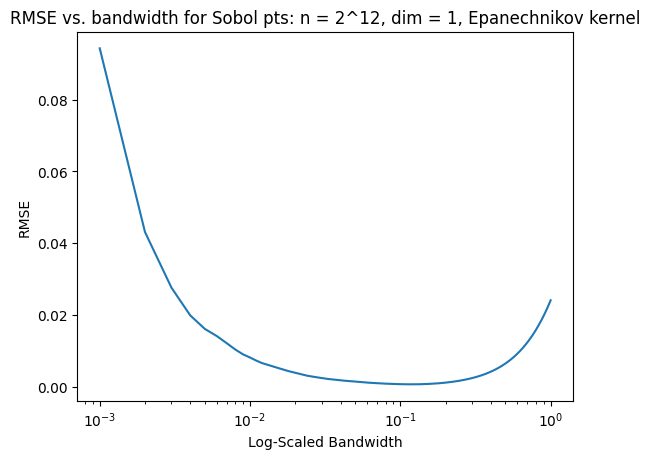

In [120]:
# # h_list = np.linspace(0.001, 1, 100)
# h_list = np.linspace(0.001, 1, 1000)
# graph_rmse_vs_bandwidth(h_list, rmse_normal, 2**7, ysob1_normal, kernel_epan, kde, xeval, "RMSE vs. bandwidth for Sobol pts: n = 2^12, dim = 1, Epanechnikov kernel")

Minimum rmse = 5.3836912283679614e-05
and corresponding bandwidth is 0.11800000000000001.
Log of optimal bandwidth is -2.137070654516472


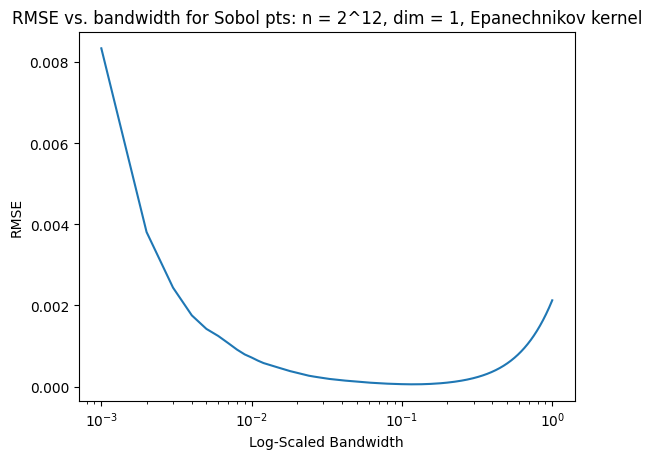

In [121]:
# # h_list = np.linspace(0.001, 1, 100)
# h_list = np.linspace(0.001, 1, 1000)
# graph_rmse_vs_bandwidth(h_list, rmse_normal, 2**14, ysob1_normal, kernel_epan, kde, xeval, "RMSE vs. bandwidth for Sobol pts: n = 2^12, dim = 1, Epanechnikov kernel")

Minimum rmse = 0.0006110324462452386
and corresponding bandwidth is 0.12240182465575017.
Log of optimal bandwidth is -2.100446001696804


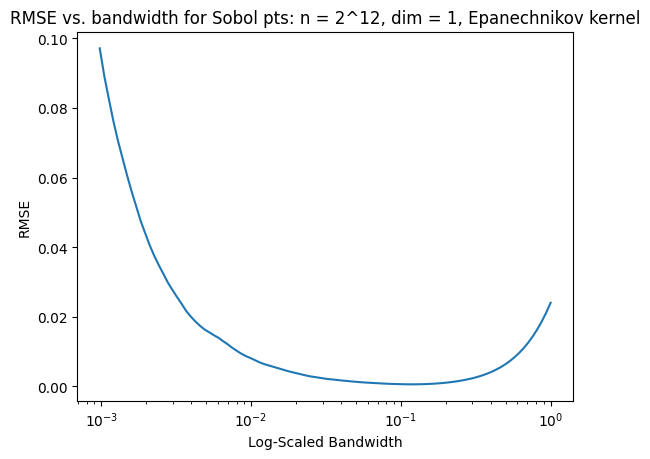

In [119]:
# h_list = np.linspace(0.001, 1, 100)
h_list = 2**np.linspace(-10, 0, 100)
graph_rmse_vs_bandwidth(h_list, rmse_normal, 2**7, ysob1_normal, kernel_epan, kde, xeval, "RMSE vs. bandwidth for Sobol pts: n = 2^12, dim = 1, Epanechnikov kernel")

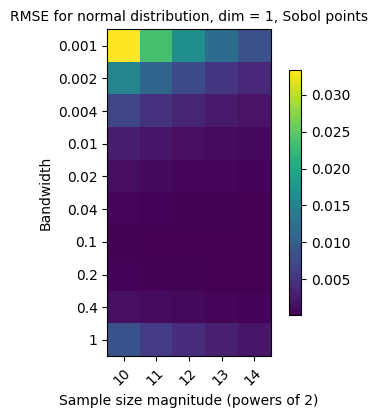

In [64]:
h_list = [0.001, 0.002, 0.004, 0.01, 0.02, 0.04, 0.1, 0.2, 0.4, 1]
n_list_power = [10, 11, 12, 13, 14]
rmse_heatmap(h_list, n_list_power, rmse_normal, ysob1_normal, kernel_epan, kde, xeval, "RMSE for normal distribution, dim = 1, Sobol points")

Sample size magnitudes, optimal bandwidths:
{'10': 0.1, '11': 0.1, '12': 0.1, '13': 0.1, '14': 0.1}
Corresponding RMSE values:
[0.00026584564835057886, 0.00018798126069762865, 0.00013292282417528943, 9.399063034881432e-05, 6.646141208764471e-05]


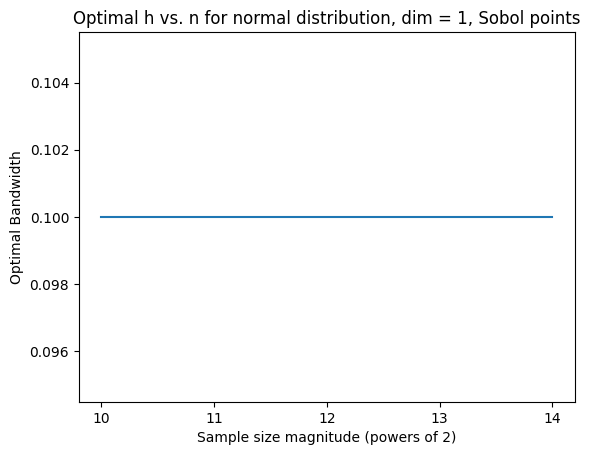

In [65]:
graph_optimal_bandwidth_vs_n(h_list, n_list_power, rmse_normal, ysob1_normal, kernel, kde, xeval, "Optimal h vs. n for normal distribution, dim = 1, Sobol points")

### Uniformly distributed random variable

In [66]:
def rmse_unif(h, n, pts, kernel, kde, xeval):
    '''
    returns rmse for a KDE that estimates a uniformly distributed random variable
    
    h = bandwidth
    n = number of points
    pts = set of iid or ld points
    kernel = kernel function
    kde = kde function
    xeval = set of points that is range of x-axis (e.g., np.linspace(-4, 8, 500))
    '''

    sum_errors = 0

    unif = xeval.copy()

    for i in range(len(unif)):
        if 0 < unif[i] < 1:
            unif[i] = 1
        else:
            unif[i] = 0
    
    rhoval = kde(kernel, pts, h, xeval)

    for i in range(500):
        sum_errors += (unif[i] - rhoval[i])**2
    
    rmse = np.sqrt((1/n)*sum_errors)
    return rmse

In [67]:
xeval = np.linspace(-4, 8, 500)
print(rmse_unif(0.1, 2**12, yiid_unif1, kernel_epan, kde, xeval))

0.015680900499944386


Minimum rmse = 0.0007833837053443135
and corresponding bandwidth is 0.0024265651546357433.
Log of optimal bandwidth is -6.021278538197505


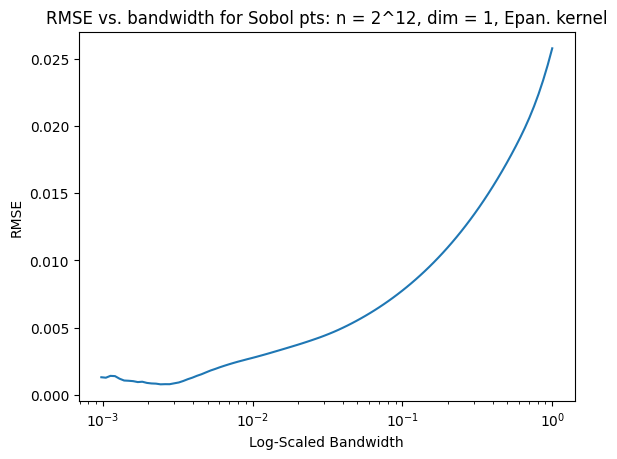

In [68]:
# h_list = np.linspace(0.001, 1, 100)
h_list = 2**np.linspace(-10, 0, 100)
graph_rmse_vs_bandwidth(h_list, rmse_unif, 2**14, ysob_unif1, kernel_epan, kde, xeval, "RMSE vs. bandwidth for Sobol pts: n = 2^12, dim = 1, Epan. kernel")

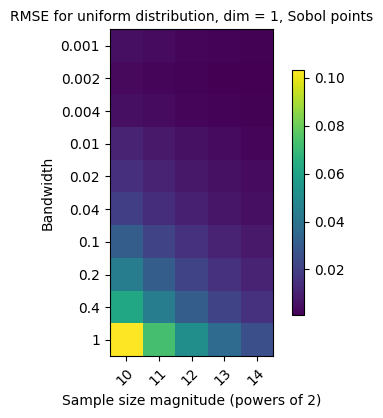

In [69]:
h_list = [0.001, 0.002, 0.004, 0.01, 0.02, 0.04, 0.1, 0.2, 0.4, 1]
n_list_power = [10, 11, 12, 13, 14]
rmse_heatmap(h_list, n_list_power, rmse_unif, ysob_unif1, kernel_epan, kde, xeval, "RMSE for uniform distribution, dim = 1, Sobol points")

Sample size magnitudes, optimal bandwidths:
{'10': 0.002, '11': 0.002, '12': 0.002, '13': 0.002, '14': 0.002}
Corresponding RMSE values:
[0.0034552219657859387, 0.00244321088251195, 0.0017276109828929694, 0.001221605441255975, 0.0008638054914464847]


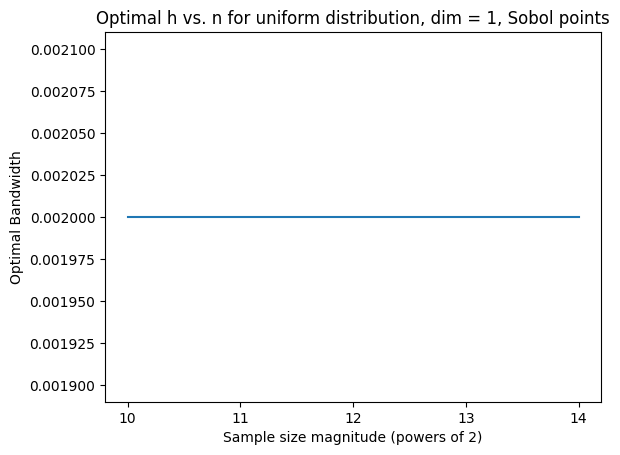

In [70]:
graph_optimal_bandwidth_vs_n(h_list, n_list_power, rmse_unif, ysob_unif1, kernel, kde, xeval, "Optimal h vs. n for uniform distribution, dim = 1, Sobol points")

### Sum of 2 uniform random variables (triangular)

In [71]:
def rmse_triangular(h, n, pts, kernel, kde, xeval):
    '''
    returns rmse for a KDE that estimates a random variable that is the sum of 2 uniform rv's (follows a triangular distribution)
    
    h = bandwidth
    n = number of points
    pts = set of iid or ld points
    kernel = kernel function
    kde = kde function
    xeval = set of points that is range of x-axis (e.g., np.linspace(-4, 8, 500))
    '''

    sum_errors = 0

    triangular = xeval.copy()
    
    for i in range(len(triangular)):
        if 0 < triangular[i] < 1:
            triangular[i] = triangular[i]
        elif 1 <= triangular[i] < 2:
            triangular[i] = 2 - triangular[i]
        else:
            triangular[i] = 0
    
    rhoval = kde(kernel, pts, h, xeval)

    for i in range(500):
        sum_errors += (triangular[i] - rhoval[i])**2
    
    rmse = np.sqrt((1/n)*sum_errors)
    return rmse

In [72]:
def testfun_triangular(x, coord_wts = 1):  #takign one uniform rv and transofmring into a normal 
    wtx= np.multiply(x, coord_wts)

    # Parameters for the triangular distribution
    a = 0  # lower limit
    c = 1  # mode
    b = 2  # upper limit

    # Apply the inverse CDF method for the triangular distribution
    def inverse_triangular_cdf(pts, a, c, b):
        F_c = (c - a) / (b - a)
        return np.where(pts < F_c,
                        a + np.sqrt(pts * (b - a) * (c - a)),
                        b - np.sqrt((1 - pts) * (b - a) * (b - c)))

    triangular_rv = inverse_triangular_cdf(wtx, a, c, b)
    return triangular_rv

In [73]:
yiid1_triangular=testfun_triangular(iidpts1)
yiid3_triangular=testfun_triangular(iidpts3)

ysob1_triangular=testfun_triangular(sobpts1)
ysob3_triangular=testfun_triangular(sobpts3)

In [74]:
xeval = np.linspace(-4, 8, 500)
print(rmse_triangular(0.1, 2**12, yiid1_triangular, kernel_epan, kde, xeval))

0.0029887248177592357


Minimum rmse = 7.319740602185386e-05
and corresponding bandwidth is 0.024458244138135844.
Log of optimal bandwidth is -3.7107879363310206


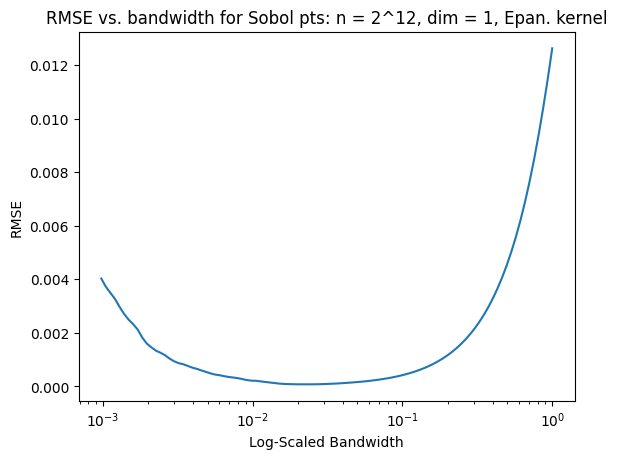

In [75]:
# h_list = np.linspace(0.001, 1, 100)
h_list = 2**np.linspace(-10, 0, 100)
graph_rmse_vs_bandwidth(h_list, rmse_triangular, 2**14, ysob1_triangular, kernel_epan, kde, xeval, "RMSE vs. bandwidth for Sobol pts: n = 2^12, dim = 1, Epan. kernel")

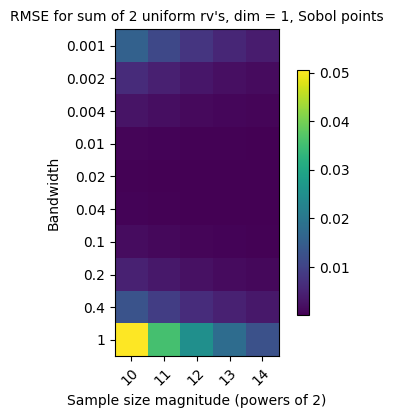

In [76]:
h_list = [0.001, 0.002, 0.004, 0.01, 0.02, 0.04, 0.1, 0.2, 0.4, 1]
n_list_power = [10, 11, 12, 13, 14]
rmse_heatmap(h_list, n_list_power, rmse_triangular, ysob1_triangular, kernel_epan, kde, xeval, "RMSE for sum of 2 uniform rv's, dim = 1, Sobol points")

Sample size magnitudes, optimal bandwidths:
{'10': 0.02, '11': 0.02, '12': 0.02, '13': 0.02, '14': 0.02}
Corresponding RMSE values:
[0.00033844709447569535, 0.00023931823557664828, 0.00016922354723784768, 0.00011965911778832414, 8.461177361892384e-05]


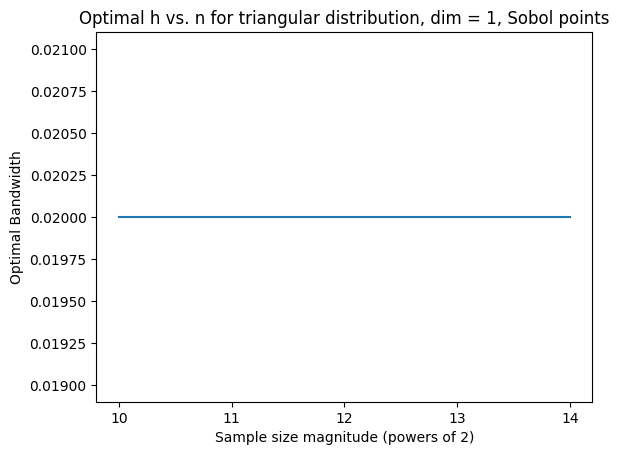

In [77]:
graph_optimal_bandwidth_vs_n(h_list, n_list_power, rmse_triangular, ysob1_triangular, kernel, kde, xeval, "Optimal h vs. n for triangular distribution, dim = 1, Sobol points")

### Exponential Distribution

In [78]:
from scipy.stats import expon

In [79]:
def rmse_exp(h, n, pts, kernel, kde, xeval):
    '''
    returns rmse for a KDE that estimates a random variable with an exponential distribution
    
    h = bandwidth
    n = number of points
    pts = set of iid or ld points
    kernel = kernel function
    kde = kde function
    xeval = set of points that is range of x-axis (e.g., np.linspace(-4, 8, 500))
    '''

    sum_errors = 0

    exp = xeval.copy()

    for i in range(len(exp)):
        exp[i] = expon.pdf(exp[i])
    
    rhoval = kde(kernel, pts, h, xeval)

    for i in range(500):
        sum_errors += (exp[i] - rhoval[i])**2
    
    rmse = np.sqrt((1/n)*sum_errors)
    return rmse

In [80]:
xeval = np.linspace(-4, 8, 500)
print(rmse_exp(0.1, 2**12, ysob3_exp, kernel_epan, kde, xeval))

0.010753612449015458


Minimum rmse = 0.0007903225641086875
and corresponding bandwidth is 0.01055699783544401.
Log of optimal bandwidth is -4.550966337009742


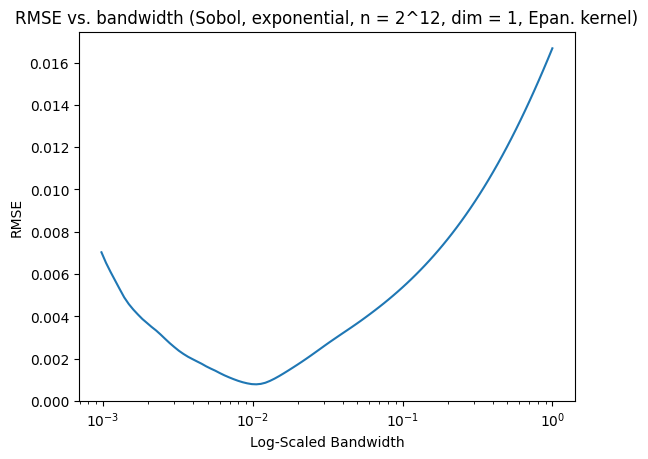

In [81]:
# h_list = np.linspace(0.001, 1, 100)
h_list = 2**np.linspace(-10, 0, 100)
graph_rmse_vs_bandwidth(h_list, rmse_exp, 2**14, ysob1_exp, kernel_epan, kde, xeval, "RMSE vs. bandwidth (Sobol, exponential, n = 2^12, dim = 1, Epan. kernel)")

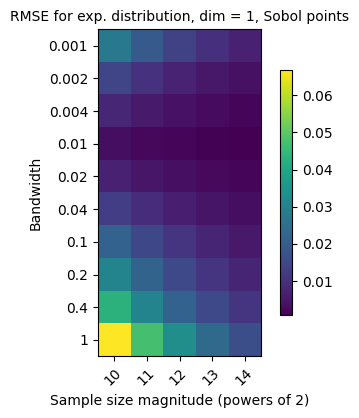

In [82]:
h_list = [0.001, 0.002, 0.004, 0.01, 0.02, 0.04, 0.1, 0.2, 0.4, 1]
n_list_power = [10, 11, 12, 13, 14]
rmse_heatmap(h_list, n_list_power, rmse_exp, ysob1_exp, kernel_epan, kde, xeval, "RMSE for exp. distribution, dim = 1, Sobol points")

Sample size magnitudes, optimal bandwidths:
{'10': 0.01, '11': 0.01, '12': 0.01, '13': 0.01, '14': 0.01}
Corresponding RMSE values:
[0.004495020574464396, 0.0031784595297768246, 0.002247510287232198, 0.0015892297648884123, 0.001123755143616099]


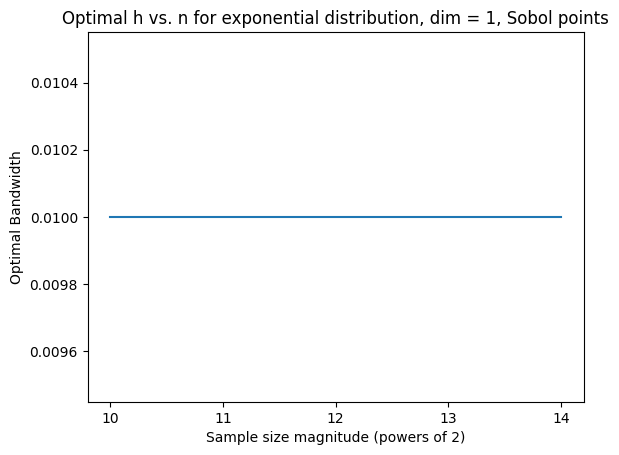

In [83]:
graph_optimal_bandwidth_vs_n(h_list, n_list_power, rmse_exp, ysob1_exp, kernel, kde, xeval, "Optimal h vs. n for exponential distribution, dim = 1, Sobol points")

### Laplace Distribution

The inverse CDF of the Laplace distribution with location parameter 𝜇 and scale parameter 𝑏 is given by:
$$
F^{-1}(x) = \text{𝜇} - \text{𝑏} \cdot \text{sign}(x-0.5) \cdot \text{ln}(1-2|x-0.5|)
$$

where $x$ is a uniform random variable in the interval $[0,1]$.

In [84]:
def rmse_laplace(h, n, pts, kernel, kde, xeval):
    '''
    returns rmse for a KDE that estimates a random variable with a laplace distribution

    h = bandwidth
    n = number of points
    pts = set of iid or ld points
    kernel = kernel function
    kde = kde function
    xeval = set of points that is range of x-axis (e.g., np.linspace(-4, 8, 500))
    '''

    sum_errors = 0

    laplace = xeval.copy()
    
    # Define location (mean) and scale parameters
    loc = 0
    scale = 1.0
 
    # Create a Laplace distribution object
    laplace_dist = stats.laplace(loc, scale)

    for i in range(len(laplace)):
        laplace[i] = laplace_dist.pdf(laplace[i])
    
    rhoval = kde(kernel, pts, h, xeval)

    for i in range(500):
        sum_errors += (laplace[i] - rhoval[i])**2
    
    rmse = np.sqrt((1/n)*sum_errors)
    return rmse

In [85]:
def testfun_laplace(x, coord_wts = 1):  #takign one uniform rv and transforming into a laplace 
    wtx= np.multiply(x, coord_wts)

    def uniform_to_laplace(u, mu=0, b=1):
        return mu - b * np.sign(u - 0.5) * np.log(1 - 2 * np.abs(u - 0.5))

    laplace_rv = uniform_to_laplace(wtx, mu=0, b=1)
    return laplace_rv

In [86]:
yiid1_laplace=testfun_laplace(iidpts1)
yiid3_laplace=testfun_laplace(iidpts3)

ysob1_laplace=testfun_laplace(sobpts1)
ysob3_laplace=testfun_laplace(sobpts3)

In [87]:
xeval = np.linspace(-4, 8, 500)
print(rmse_laplace(0.1, 2**12, ysob1_laplace, kernel_epan, kde, xeval))

0.0003463783362783635


Minimum rmse = 0.00014159345644080645
and corresponding bandwidth is 0.06990871667220502.
Log of optimal bandwidth is -2.6605649354826184


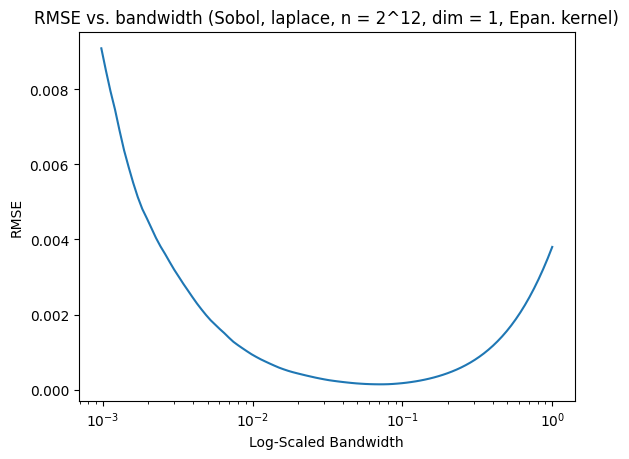

In [88]:
# h_list = np.linspace(0.001, 1, 100)
h_list = 2**np.linspace(-10, 0, 100)
graph_rmse_vs_bandwidth(h_list, rmse_laplace, 2**14, ysob1_laplace, kernel_epan, kde, xeval, "RMSE vs. bandwidth (Sobol, laplace, n = 2^12, dim = 1, Epan. kernel)")

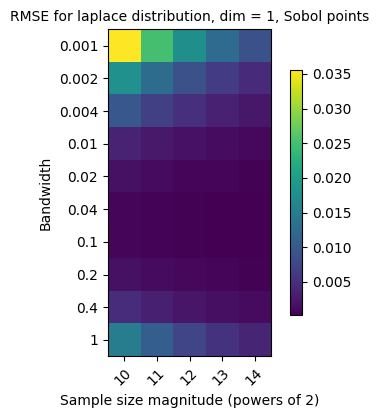

In [89]:
h_list = [0.001, 0.002, 0.004, 0.01, 0.02, 0.04, 0.1, 0.2, 0.4, 1]
n_list_power = [10, 11, 12, 13, 14]
rmse_heatmap(h_list, n_list_power, rmse_laplace, ysob1_laplace, kernel_epan, kde, xeval, "RMSE for laplace distribution, dim = 1, Sobol points")

Sample size magnitudes, optimal bandwidths:
{'10': 0.04, '11': 0.04, '12': 0.04, '13': 0.04, '14': 0.04}
Corresponding RMSE values:
[0.0005892277300846522, 0.0004166469236060143, 0.0002946138650423261, 0.00020832346180300716, 0.00014730693252116306]


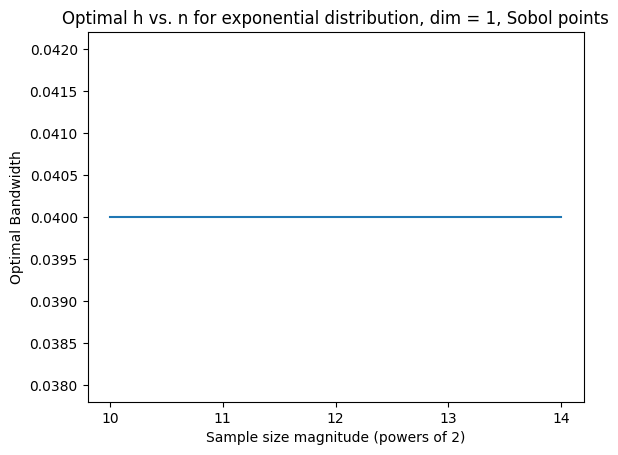

In [90]:
graph_optimal_bandwidth_vs_n(h_list, n_list_power, rmse_laplace, ysob1_laplace, kernel, kde, xeval, "Optimal h vs. n for exponential distribution, dim = 1, Sobol points")

### Weighted sum of normals

If $X_{1}, X_{2}, ..., X_{d}$ all follow the standard uniform distribution, $X_{i} \sim \text{Unif}(0,1)$, then the random variable 
$$
Y = w_{1} \cdot \Phi^{-1}(X_{1}) + w_{2} \cdot \Phi^{-1}(X_{2}) + ... + w_{d} \cdot \Phi^{-1}(X_{d})
$$ 
follows a normal distribution with expectation $0$ and variance $w_{1}^2 + w_{2}^2 + ... + w_{d}^2$. 

In [91]:
# from scipy.stats import norm 
# import numpy as np

In [92]:
def rmse_sum_normals(h, n, pts, kernel, kde, xeval, weights):
    '''
    returns rmse for a KDE that estimates a random variable that is the weighted sum of uniformly distributed random variables

    h = bandwidth
    n = number of points
    pts = set of iid or ld points
    kernel = kernel function
    kde = kde function
    xeval = set of points that is range of x-axis (e.g., np.linspace(-4, 8, 500))
    weights = a list of numbers that are the weights for the sum of normals
    '''

    sum_errors = 0

    sum_normals = xeval.copy()
    
    # Define location (mean) and scale (standard deviation) parameters
    loc = 0
    scale = np.sqrt(sum(w*w for w in weights))
 
    for i in range(len(sum_normals)):
       sum_normals[i]=norm.pdf(sum_normals[i], loc, scale)
    
    rhoval = kde(kernel, pts, h, xeval)

    for i in range(500):
        sum_errors += (sum_normals[i] - rhoval[i])**2
    
    rmse = np.sqrt((1/n)*sum_errors)
    return rmse

In [93]:
# def copy_testfun_sum_normals(x, weights):  #takign one uniform rv and transforming into a sum of normals

#     y = np.zeros(x.shape[0])

#     for dim in range(x.shape[1]):
#         normal = weights[dim] * norm.ppf(x[:, dim])
#         for i in range(y.shape[0]):
#             y[i] += normal[i]

#     return y

In [94]:
def testfun_sum_normals(x, weights):  #takign one uniform rv and transforming into a sum of normals

    y = np.sum(norm.ppf(x)*weights, axis = 1)
    # y = np.sum(x*weights, axis = 1)  # testing out this function

    return y

In [95]:
## testing out testfun_sum_normals without norm.ppf
# x = np.array([[0.2, 0.3, 0.4], [0.1, 0.2, 0.3]])
# weights = [1.0, 0.5, 0.25]
# print(copy_testfun_sum_normals(x, weights))

In [96]:
yiid1_sum_normals=testfun_sum_normals(iidpts1, [1])
yiid3_sum_normals=testfun_sum_normals(iidpts3, [1, 1, 1])

ysob1_sum_normals=testfun_sum_normals(sobpts1, [1])
ysob3_sum_normals=testfun_sum_normals(sobpts3, [1, 1, 1])

In [97]:
xeval = np.linspace(-4, 8, 500)
weights_1 = [1]
weights_3 = [1, 1, 1]
print(rmse_sum_normals(0.1, 2**10, yiid1_sum_normals, kernel_epan, kde, xeval, weights_1))

0.007054378295646693


Minimum rmse = 0.0003276500965248075
and corresponding bandwidth is 0.612562643272352.
Log of optimal bandwidth is -0.4901040670625881


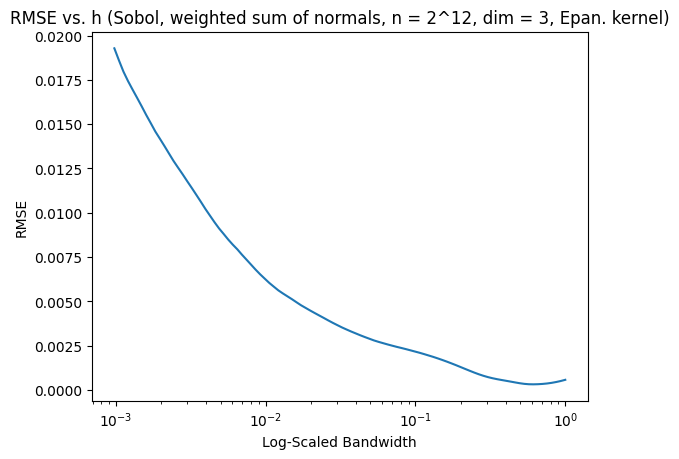

In [98]:
# h_list = np.linspace(0.001, 1, 100)
h_list = 2**np.linspace(-10, 0, 100)
weighted_graph_rmse_vs_bandwidth(h_list, rmse_sum_normals, 2**14, ysob3_sum_normals, kernel_epan, kde, xeval, weights_3, "RMSE vs. h (Sobol, weighted sum of normals, n = 2^12, dim = 3, Epan. kernel)")

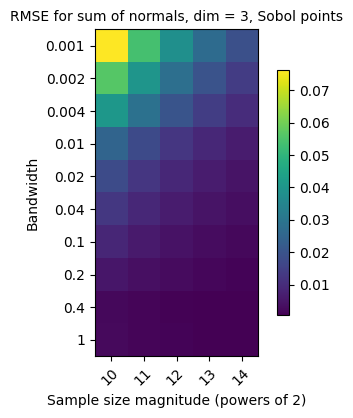

In [99]:
h_list = [0.001, 0.002, 0.004, 0.01, 0.02, 0.04, 0.1, 0.2, 0.4, 1]
n_list_power = [10, 11, 12, 13, 14]
weighted_rmse_heatmap(h_list, n_list_power, rmse_sum_normals, ysob3_sum_normals, kernel_epan, kde, xeval, weights_3, "RMSE for sum of normals, dim = 3, Sobol points")

Sample size magnitudes, optimal bandwidths:
{'10': 0.4, '11': 0.4, '12': 0.4, '13': 0.4, '14': 0.4}
Corresponding RMSE values:
[0.0014109357533885624, 0.0009976822390396027, 0.0007054678766942812, 0.0004988411195198014, 0.0003527339383471406]


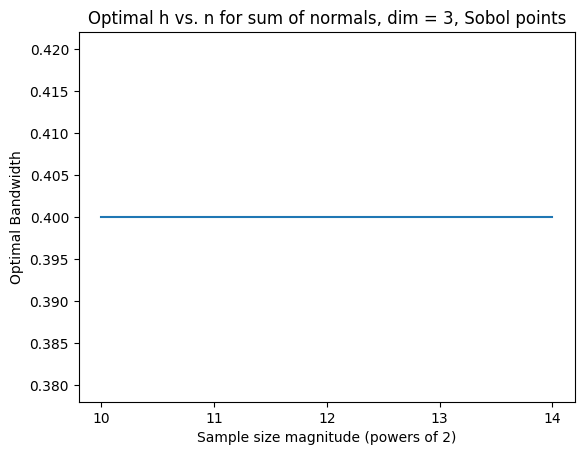

In [100]:
weighted_graph_optimal_bandwidth_vs_n(h_list, n_list_power, rmse_sum_normals, ysob3_sum_normals, kernel, kde, xeval, weights_3, "Optimal h vs. n for sum of normals, dim = 3, Sobol points")

### Chi-squared (sum of squared Gaussians)
A chi-square-distributed random variable with $k$ degrees of freedom is defined as the sum of $k$ squared standard normal random variables:
$$
X_{1}, ..., X_{k} \rightarrow Y = \sum_{i=1}^{k} X_{i}^{2} = \chi^{2}(k)
$$
https://statproofbook.github.io/P/chi2-pdf.html

In [122]:
from scipy.stats import chi2

In [ ]:
def rmse_chi_squared(h, n, pts, kernel, kde, xeval, df):
    '''
    returns rmse for a KDE that estimates a random variable that is the sum of df squared gaussians, i.e., chi-squared with degrees of freedom = df

    h = bandwidth
    n = number of points
    pts = set of iid or ld points
    kernel = kernel function
    kde = kde function
    xeval = set of points that is range of x-axis (e.g., np.linspace(-4, 8, 500))
    df = degrees of freedom (how many squared gaussians you are summing)
    '''

    sum_errors = 0

    chi_squared = xeval.copy()
 
    for i in range(len(chi_squared)):
       chi_squared[i] = chi_squared.pdf(chi_squared, df)
    
    rhoval = kde(kernel, pts, h, xeval)

    for i in range(500):
        sum_errors += (chi_squared[i] - rhoval[i])**2
    
    rmse = np.sqrt((1/n)*sum_errors)
    return rmse

## Using dictionaries for RMSE

In [101]:
import scipy as sc

[1. 1. 0.]
0.28209479177387814


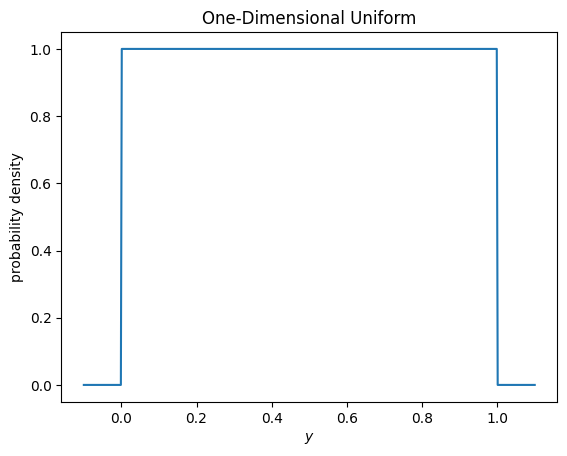

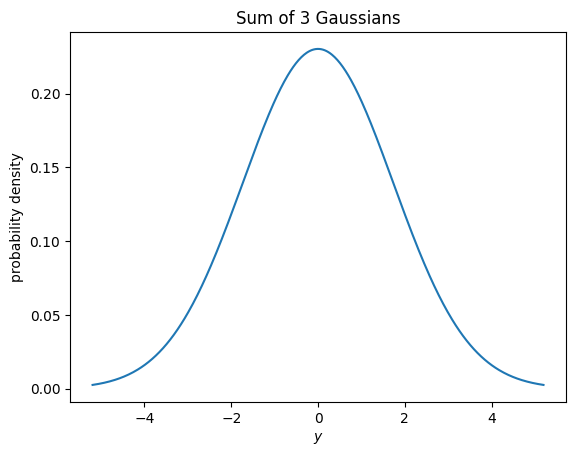

In [102]:
uniform_1 = {
    "f" : lambda x: x[:,0],  #just take the first coordinate
    "density" : lambda y,d : np.where((y >= 0) & (y <= 1),1.,0.),
    "y_domain" : lambda d : np.array([-0.1,1.1]),
    "name" : lambda d=1 : "One-Dimensional Uniform"}
sum_d_Gauss = {
    "f" : lambda x: np.sum(sc.stats.norm.ppf(x),axis = 1),  #sum of d standard Gaussians is a Gaussian with variance 
    "density" : lambda y,d : sc.stats.norm.pdf(y,scale = np.sqrt(d)),
     "y_domain" : lambda d : np.array([-3*np.sqrt(d),3*np.sqrt(d)]),
    "name" : lambda d : f"Sum of {d:.0f} Gaussians"}
print(uniform_1["density"](np.array([0.5,1,1.5]),1))
print(sum_d_Gauss["density"](0,2))
ex_densities = [uniform_1,sum_d_Gauss]
d = 3
for ii in range(len(ex_densities)):
    fig,ax = plt.subplots()
    domain = ex_densities[ii]["y_domain"](d)
    yplot = np.linspace(domain[0],domain[1],500)
    rhoplot = ex_densities[ii]["density"](yplot,d)
    ax.plot(yplot, rhoplot),
    ax.set_title(ex_densities[ii]["name"](d))
    ax.set_xlabel("$y$")
    ax.set_ylabel("probability density")

In [103]:
rmse = lambda rhoval, pdf, n : np.sqrt((1/n)*(np.sum(np.square(pdf-rhoval))))

In [104]:
uniform_1 = {
    "f" : lambda x: x[:,0],  #just take the first coordinate
    "density" : lambda y,d : np.where((y >= 0) & (y <= 1),1.,0.),
    "y_domain" : lambda d : np.array([-0.1,1.1]),
    "name" : lambda d=1 : "One-Dimensional Uniform"}

In [105]:
gaussian_1 = { # standard Gaussian
    "f" : lambda x: norm.ppf(x), 
    "density" : lambda y,d : norm.pdf(y, loc=0, scale=1),
    "y_domain" : lambda d : np.array([-3.1,3.1]),
    "name" : lambda d=1 : "One-Dimensional Standard Gaussian"}

In [106]:
triangular_1 = { # triangular = sum of 2 uniform variables, min = 0, max = 2, mode = 1
    "f" : lambda x: np.where(x < 0.5,
                        0 + np.sqrt(x * (2) * (1)),
                        2 - np.sqrt((1 - x) * (2) * (1))), 
    "density" : lambda y,d : np.where((0 < y) & (y < 1), y, 
                                      np.where((1 <= y) & (y < 2), 2 - y, 
                                               0)),
    "y_domain" : lambda d : np.array([-0.1, 2.1]),
    "name" : lambda d=1 : "One-Dimensional Sum of 2 Uniforms (Triangular)"}

In [107]:
# from scipy.stats import expon

exp_1 = { # exponential, lambda = 1
    "f" : lambda x: -np.log(x), 
    "density" : lambda y,d : expon.pdf(y),
    "y_domain" : lambda d : np.array([-0.1,4.1]),
    "name" : lambda d=1 : "One-Dimensional Exponential (lambda = 1)"}

In [108]:
laplace_1 = { # laplace, where mu = 0 and b = 1
    "f" : lambda x: 0 - 1 * np.sign(x - 0.5) * np.log(1 - 2 * np.abs(x - 0.5)), 
    "density" : lambda y,d : stats.laplace(0, 1).pdf(y),
    "y_domain" : lambda d : np.array([-4.1,4.1]),
    "name" : lambda d=1 : "One-Dimensional Laplace (mu = 0, b = 1)"}

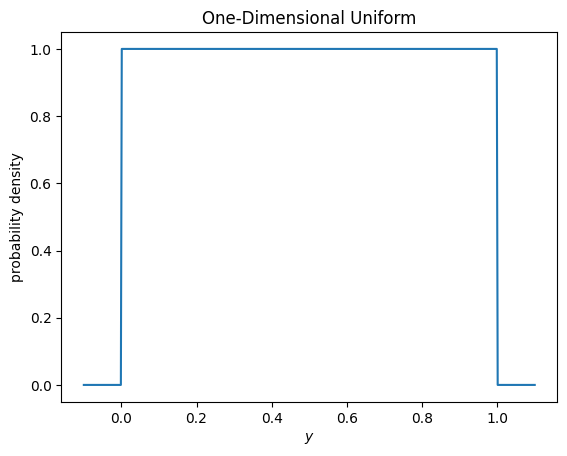

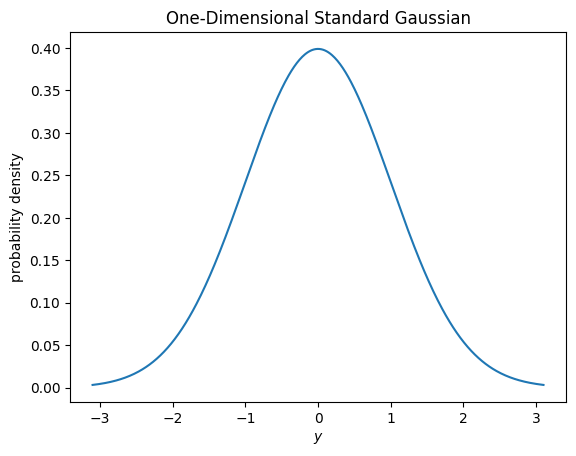

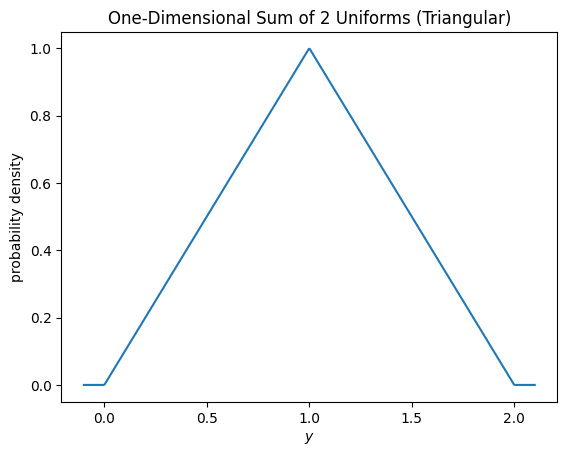

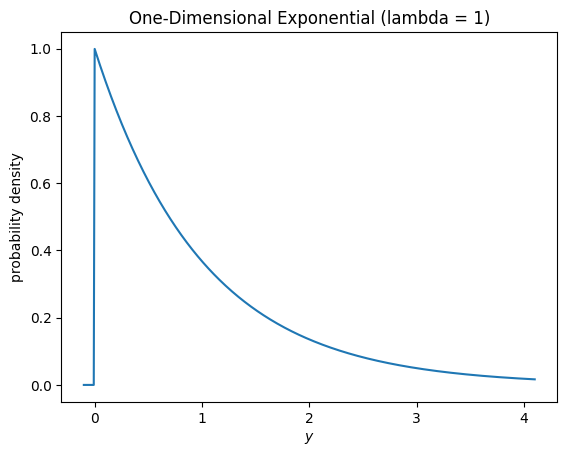

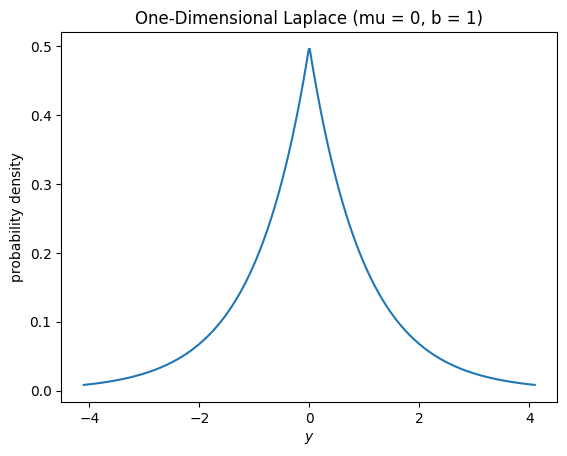

In [109]:
densities = [uniform_1, gaussian_1, triangular_1, exp_1, laplace_1]
d = 1
for ii in range(len(densities)):
    fig,ax = plt.subplots()
    domain = densities[ii]["y_domain"](d)
    yplot = np.linspace(domain[0],domain[1],500)
    rhoplot = densities[ii]["density"](yplot,d)
    ax.plot(yplot, rhoplot),
    ax.set_title(densities[ii]["name"](d))
    ax.set_xlabel("$y$")
    ax.set_ylabel("probability density")

In [110]:
weight_sum_d_Gauss = {
    "f" : lambda x, weights: np.sum(norm.ppf(x)*weights, axis = 1),  #sum of d standard Gaussians with weights 
    "density" : lambda y, weights : sc.stats.norm.pdf(y,scale = np.sqrt(sum(w*w for w in weights))),
     "y_domain" : lambda weights : np.array([-3*np.sqrt(sum(w*w for w in weights)),3*np.sqrt(sum(w*w for w in weights))]),
    "name" : lambda d : f"Weighted Sum of {d:.0f} Gaussians"}

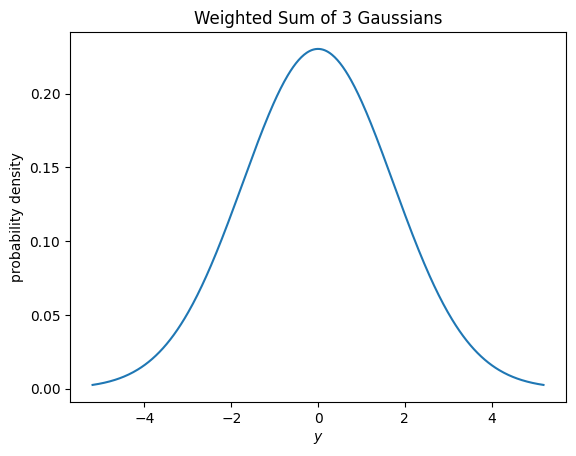

In [111]:
weighted_densities = [weight_sum_d_Gauss]
d = 3
weights_3 = [1,1,1]
for ii in range(len(weighted_densities)):
    fig,ax = plt.subplots()
    domain = weighted_densities[ii]["y_domain"](weights_3)
    yplot = np.linspace(domain[0],domain[1],500)
    rhoplot = weighted_densities[ii]["density"](yplot,weights_3)
    ax.plot(yplot, rhoplot),
    ax.set_title(weighted_densities[ii]["name"](d))
    ax.set_xlabel("$y$")
    ax.set_ylabel("probability density")

In [112]:
def new_graph_rmse_vs_bandwidth(distn_dict, h_list, n, pts, kernel, kde, xeval, graph_title):
    '''
    generates a graph of rmse vs. log-scaled bandwidth
    
    distn_dict = dictionary that defines the distribution we are estimating
    h_list = list of bandwidths to be tested (log-scaled bandwidth on x-axis)
    n = number of points
    pts = set of untransformed points (IID or LD)
    kernel = kernel function
    kde = kernel density estimator function
    xeval = set of points that is range of x-axis (e.g., np.linspace(-4, 8, 500))
    graph_title = a string that will become title of graph
    '''

    rmse_list = []
    for h in h_list:
        rhoval = kde(kernel, distn_dict['f'](pts), h, xeval)
        rmse_list.append(rmse(rhoval, distn_dict['density'](xeval, 1), n))

    min_index = rmse_list.index(min(rmse_list))
    print("Minimum rmse = " 
        + str(rmse_list[min_index]) 
        + "\nand corresponding bandwidth is " 
        + str(h_list[min_index])
        + ".\nLog of optimal bandwidth is "
        + str(np.log(h_list[min_index])))
    
    fig, ax = plt.subplots()
    ax.plot(h_list, rmse_list)
    ax.set_title(graph_title)
    ax.set_xlabel('Log-Scaled Bandwidth')
    ax.set_ylabel('RMSE')
    ax.set_xscale('log')

In [113]:
def weighted_new_graph_rmse_vs_bandwidth(distn_dict, h_list, n, pts, kernel, kde, xeval, weights, graph_title):
    '''
    generates a graph of rmse vs. log-scaled bandwidth
    
    distn_dict = dictionary that defines the distribution we are estimating
    h_list = list of bandwidths to be tested (log-scaled bandwidth on x-axis)
    n = number of points
    pts = set of untransformed points (IID or LD)
    kernel = kernel function
    kde = kernel density estimator function
    xeval = set of points that is range of x-axis (e.g., np.linspace(-4, 8, 500))
    weights = list of weights
    graph_title = a string that will become title of graph
    '''

    rmse_list = []
    for h in h_list:
        rhoval = kde(kernel, distn_dict['f'](pts, weights), h, xeval)
        rmse_list.append(rmse(rhoval, distn_dict['density'](xeval, weights), n))

    min_index = rmse_list.index(min(rmse_list))
    print("Minimum rmse = " 
        + str(rmse_list[min_index]) 
        + "\nand corresponding bandwidth is " 
        + str(h_list[min_index])
        + ".\nLog of optimal bandwidth is "
        + str(np.log(h_list[min_index])))
    
    fig, ax = plt.subplots()
    ax.plot(h_list, rmse_list)
    ax.set_title(graph_title)
    ax.set_xlabel('Log-Scaled Bandwidth')
    ax.set_ylabel('RMSE')
    ax.set_xscale('log')

Minimum rmse = 0.008624642453118945
and corresponding bandwidth is 0.024458244138135844.
Log of optimal bandwidth is -3.7107879363310206


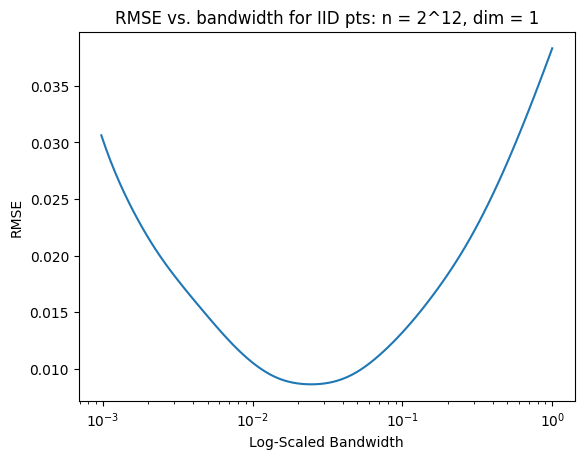

In [114]:
xeval = np.linspace(-4, 8, 500)
h_list = 2**np.linspace(-10, 0, 100)
new_graph_rmse_vs_bandwidth(exp_1, h_list, 2**12, iidpts1, kernel, kde, xeval, "RMSE vs. bandwidth for IID pts: n = 2^12, dim = 1")

Minimum rmse = 0.0013465327095467693
and corresponding bandwidth is 0.2644025655552628.
Log of optimal bandwidth is -1.330282467741309


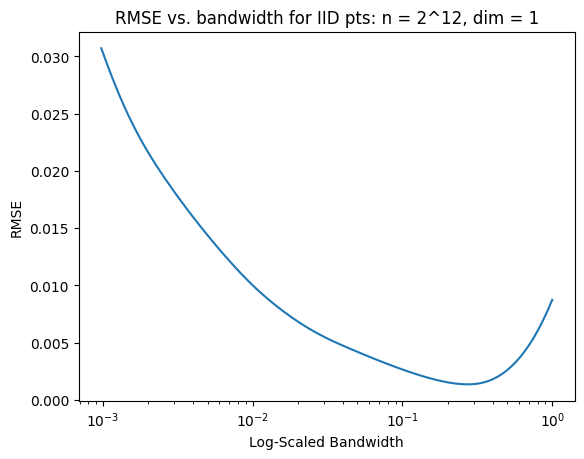

In [115]:
xeval = np.linspace(-4, 8, 500)
h_list = 2**np.linspace(-10, 0, 100)
weights_1 = [1]
weights_3 = [1,1,1]
weighted_new_graph_rmse_vs_bandwidth(weight_sum_d_Gauss, h_list, 2**12, iidpts1, kernel, kde, xeval, weights_1, "RMSE vs. bandwidth for IID pts: n = 2^12, dim = 1")

## Profiling code

In [116]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from copy import deepcopy
import sympy as sy
import sympy.stats
import pprofile
import sys

In [117]:
## defining functions
# QMC Point Generators
def gen_iid_ld_pts(dimen = 3, n = 2**12):
    """
    Generate IID, Sobol, Lattic, DNB2, and Halton sample points,
    based on dimension and smaple size.
    """
    coord_wts = 2.0**(-np.array(range(0, dimen)))
    iidpts = qp.IIDStdUniform(dimen).gen_samples(n)
    sobpts = qp.Sobol(dimen).gen_samples(n)
    latticepts = qp.Lattice(dimen).gen_samples(n)
    dnetb2pts = qp.DigitalNetB2(dimen).gen_samples(n)
    haltonpts = qp.Halton(dimen).gen_samples(n)
    return (iidpts, sobpts, latticepts, dnetb2pts, haltonpts)

# Kernels
# hardcoding hermite kernel coefficients
def hardcode_hermite_kernel(r):
    '''
    returns hermite coefficients for r = 0, 1, or 2
    band_width = the kernel band width, often denoted h; a smaller bandwidth means a peakier kernel
    r = number of terms in our kernel
    '''
    if r == 0:
        return sy.Matrix([[1/(math.pi)**0.5]])
    elif r == 1:
        return sy.Matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5)]])
    elif r == 2:
        return sy.Matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5), 1/(32*(math.pi)**0.5)]])
    else:
        raise ValueError("Invalid input. r must be 0, 1, or 2.")

# hardcoded: define hermite kernel for r = 0 (corresponds to r = 1 in the original case)
def hardcode_hermite_kernel_weight(y, r = 0):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    # print(coef)
    # poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y) * coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0, r):
        k += sp.special.hermite(2*ii)(y) * coef[0][ii] #add the additional terms
    k *= np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

# hardcoding hermite kernel coefficients without sympy
def hardcode_hermite_kernel_simple(r):
    '''
    returns hermite coefficients for r = 0, 1, or 2
    band_width = the kernel band width, often denoted h; a smaller bandwidth means a peakier kernel
    r = number of terms in our kernel
    '''
    if r==0:
        return np.matrix([[1/(math.pi)**0.5]])
    elif r==1:
        return np.matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5)]])
    elif r==2:
        return np.matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5), 1/(32*(math.pi)**0.5)]])
    else:
        raise ValueError("Invalid input. r must be 0, 1, or 2.")
    
# using simplified np.matrix for coefficients, instead of sympy.matrix
def hardcode_hermite_kernel_weight_v2(y, r = 0):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel_simple(r = r)))
    # print(coef)
    # poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y) * coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0, r):
        k += sp.special.hermite(2*ii)(y) * coef[0][ii] #add the additional terms
    k *= np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k
    
# hardcoded without scipy: define hermite kernel for r = 0 (corresponds to r = 1 in the original case)
# for some reason, not returning same values as original kernel
def simple_hardcode_hermite_kernel_weight(y, r = 0):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    hermite_polys = [sp.poly1d([1.]), sp.poly1d([4.,  0., -2.]), sp.poly1d([ 1.6000000e+01,  0.0000000e+00, -4.8000000e+01, -8.8817842e-16,
        1.2000000e+01])]
    # print(coef)
    # poly = sp.special.hermite(0)
    # print(poly)
    k = sp.poly1d([1.])(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += hermite_polys[r](y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

# PDFs
# Unamed distribution
def testfun(x):
    return 10 * np.exp(-x) * np.sin(np.pi*x)

# Guassian distribution
def guass_distr(x, coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x, coord_wts)
    y = 10 * np.exp(-wtx.sum(1)) * np.sin(np.pi * wtx.sum(1))
    #y = x[:,0] # if x is uniform, then y is uniform
    return y

# KDEs
def kde_pt(kernel, ypts, bandwidth, yeval):
    return np.mean(kernel((yeval-ypts) / bandwidth)) / bandwidth

# def estimated_pts(x):
#     return kde_pt(hardcode_hermite_kernel_weight, pts, h, x)

# def squared_difference_pts(x):
#     return (hardcode_hermite_kernel_weight - estimated_pts(x))**2

# Integration operation from SciPy
def integration_test(h, pts, kde, kernel, true_function):
        def estimated_pts(x):
            return kde(kernel, pts, h, x)
        def squared_difference_pts(x):
            return (true_function(x) - estimated_pts(x))**2
        mise, error = sp.integrate.quad(squared_difference_pts, -4, 8) # This seems to be taking the longest. Will investigate.
        return (mise, error)

# All operations
def optimal_h(h_space, pts, kde, kernel, true_function):
    '''
    returns optimal bandwidth and lowest value of MISE
    h_space: a set of bandwidths to be tested (e.g., np.linspace(0.001, 3, 100))
    pts: set of randomly generated points (IID or LD)
    kde: kde function
    kernel: function that defines kernel
    true_function: function that we are trying to estimate (e.g., f(x), laplace, uniform, exponential, etc.)
    '''
    h_optimal = 0
    lowest_mise = np.inf
    for h in h_space:
        def estimated_pts(x):
            return kde(kernel, pts, h, x)
        def squared_difference_pts(x):
            return (true_function(x) - estimated_pts(x))**2
        mise, error = sp.integrate.quad(squared_difference_pts, -4, 8) # TODO: Fix this interval of integration so that it makes sense. Should probably be parameterized as well.
        if mise < lowest_mise:
            lowest_mise = mise
            h_optimal = h

    return(lowest_mise, h_optimal)

In [ ]:
# Functions to test
# Alternatives to SciPy's integration

iidpts1, sobpts1, latticepts1, dnetb2pts1, haltonpts1 = gen_iid_ld_pts(dimen = 1, n = 2**12)
yiid1 = guass_distr(iidpts1)
test_option = '6'

profiler = pprofile.Profile()
with profiler:
    if test_option in ('optimal_h' ,'0'):
        result = optimal_h(np.linspace(0.001, 2, 2), yiid1, kde_pt, hardcode_hermite_kernel_weight, testfun)
    elif test_option in ('kde_pt', '1'):
        result = kde_pt(hardcode_hermite_kernel_weight, yiid1, 0.5, 2.0)
    # elif test_option == 'hardcode_hermite_kernel_weight':
    #     # result = hardcode_hermite_kernel_weight(y, r)
    elif test_option in ('hardcode_hermite_kernel', '2'):
        r_number = int(2)
        print(hardcode_hermite_kernel(r_number))
    elif test_option in ('hardcode_hermite_kernel', '3'):
        r_number = int(2)
        result = hardcode_hermite_kernel_weight(y=yiid1, r=r_number)
    elif test_option in ('integration_test', '4'):
        mise, error = integration_test(0.1, yiid1, kde_pt, hardcode_hermite_kernel_weight, testfun)
    elif test_option in ('hardcode_hermite_kernel_simple', '5'):
        print(hardcode_hermite_kernel_simple(2)) # testing when r = 2
    elif test_option in ('simple_hardcode_hermite_kernel_weight', '6'):
        print(simple_hardcode_hermite_kernel_weight(y=yiid1, r=2))
    elif test_option in ('hardcode_hermite_kernel_weight_v2', '7'):
        result = hardcode_hermite_kernel_weight_v2(y=yiid1, r=2)
    else:
        raise Exception

profiler.print_stats()

In [ ]:
#testing